# Linear Quadratic Regulator

## Problem Formulation

$$
\min _{\substack{x_{1: N} \\
u_{1: N-1}}} \sum_{k=1}^{N-1} \frac{1}{2}(\underbrace{x_k^{\top} Q_k x_k}_{\text {state cost }}+\underbrace{u_k^{\top} R_k u_k}_{\text {control cost }})+\frac{1}{2} \underbrace{x_N^{\top} Q_N x_N}_{\text {terminal cost }} \\
\begin{aligned}
\\ \text { s.t. } \\
& x_{k+1} = A_k x_k+B_k u_k \\
& Q_k \succeq 0 \quad \text { (positive semi-definite) } \\
& R_k \succ 0 \quad \text { (strictly positive definite) }
\end{aligned}
$$

```{note}
$Q_k$ and $R_k$ are defined/tuned by the human, so they can always be chosen satisfy their requirements.
```

The LQR formulation is applicable to a wide range of linear and non-linear systems. This is why it is so prominent in this field. It is computationally tractable.

The time-varying description above is general. For example, linearizing dynamics about the knot points leads to a LQR formulation that can be applied to a non-linear system. 

It is "time invariant" if $A_k = A$, $B_k = B$ and $Q_k = Q$, $R_k = R$. This is also applicable to surprisingly many non-linear problems. It is done by linearizing about a set point.

There are many extensions to LQR such as infinite horizon, stochastic etc.

## Solving LQR via Indirect Shooting
Plugging the cost and dynamics into Pontryagin's Principle we have.

$$
\begin{aligned}
x_{k+1} & =\nabla_\lambda H\left(x_k, u_k, \lambda_{k+1}\right)=A x_k+B u_k \\
\lambda_k & =\nabla_x H\left(x_k, u_k, \lambda_{k+1}\right)=Q x_k+A^{\intercal} \lambda_{k+1} \\
\lambda_N & =Q_N x_N \\
u_k & =\operatorname{argmin}_{\bar{u}} H\left(x_k, \bar{u}, \lambda_{k+1}\right) \\
& =-R^{-1} B^{\intercal} \lambda_{k+1}
\end{aligned}
$$

Algorithm

1. Start with initial $U_{1:N-1}$
1. Simulate ("rollout") to get $X_{1:N}$
1. Backward pass to get $\lambda$ and $\Delta u$
1. Rollout with line search on $\Delta u$
1. Go to 3. until convergence.

### Example: Double Integrator

Dynamics of a frictionless cart could be given by

$$
\dot{x}=\left[\begin{array}{c}
\dot{q} \\
\ddot{q}
\end{array}\right]=\left[\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right]\left[\begin{array}{l}
q \\
\dot{q}
\end{array}\right] = \left[\begin{array}{l}
0 \\
1
\end{array}\right]
$$

Discretizing this with Forward Euler gives


$$
x_{k+1}=\left[\begin{array}{ll}
1 & h \\
0 & 1
\end{array}\right]\left[\begin{array}{c}
q_k \\
\dot{q}_k
\end{array}\right]+\left[\begin{array}{c}
\frac{1}{2} h^2 \\
h
\end{array}\right] u_k
$$

In [55]:
import Pkg; Pkg.activate(@__DIR__);
using LinearAlgebra
using SparseArrays
using Plots

  Activating project at `/workspaces/CMU-16-745/optimalcontrol`


In [56]:
function cost(params::NamedTuple, X::Matrix, U::Matrix)
    n, N = size(X) # states and time steps

    Q = params.Q
    R = params.R
    Qn = params.Qn

    # Terminal cost
    J = 0.5 * X[:, end]' * Qn * X[:, end]

    # Step cost
    for k = 1:(N-1)
        J += 0.5 * X[:, k]' * Q * X[:, k] + 0.5 * U[:, k]' * R * U[:, k]
    end

    return J
end

function rollout(params::NamedTuple, X::Matrix, U::Matrix)
    n, N = size(X)

    A = params.A
    B = params.B

    X1 = zeros(size(X))
    X1[:, 1] = X[:, 1] # Initial condition
    for k = 1:(N-1)
        X1[:, k+1] = A * X1[:, k] + B * U[:, k]
    end
    return X1
end

rollout (generic function with 1 method)

In [57]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = 1
B = reshape([0.5*h*h; h],(2,1))

# Cost weights
Q = 1.0*I(2)
R = 0.1
Qn = 1.0*I(2)

# Package it
params = (A=A, B=B, Q=Q, R=R, Qn=Qn)

# Horizon
n = 2     # number of state
m = 1     # number of controls
Tfinal = 5.0 # final time #try larger values
N = Int(Tfinal/h)+1    # number of time steps
T = Array(range(0,h*(N-1), step=h));

# Initial guesses
x0 = [1.0; 0] # Initial conditions
X = repeat(x0, 1, N)
U = zeros(1, N-1)
Δu = ones(size(U)) # all the Δu_k
λ = zeros(n, N) # all the λ_k



2×51 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [58]:
tol = 1e-2
iterations = 0
max_iter = 1000
solved = false
X = rollout(params, X, U) # intial rollout
@show cost(params, X, U) # initial cost
for i = 1:max_iter

    # Backward pass to compute λ and Δu
    λ[:, N] = Qn * X[:, N]
    for k = N-1:-1:1
        Δu[:, k] = -(U[:, k] + (R \ B')*λ[:, k+1])
        λ[:, k] .= Q * X[:, k] + A' * λ[:, k+1]
    end

    # Forward pass with line search to compute x
    α = 1.0
    b = 1e-2 # line search tolerance
    unew = U + α .* Δu
    xnew = rollout(params, X, unew)
    line_search_success = false
    for j = 1:max_iter

        # Roll out a new trajectory
        α = 0.5 * α
        unew = U + α .* Δu
        xnew = rollout(params, X, unew)

        # Keep going until the predicted update is within reason
        if cost(params, xnew, unew) < cost(params, X, U) - b * α * (Δu * Δu')[1]
            line_search_success = true
            break
        end
    end
    if !line_search_success
        error("Line search failed")
    end

    U .= unew
    X .= xnew

    iterations += 1

    if maximum(abs.(Δu)) < tol
        solved = true
        break
    end

end

if !solved
    error("No solution found, try increasing iters")
end
    

@show iterations;
@show cost(params, X, U);


cost(params, X, U) = 25.5
iterations = 

664
cost(params, X, U) = 6.658144576322124


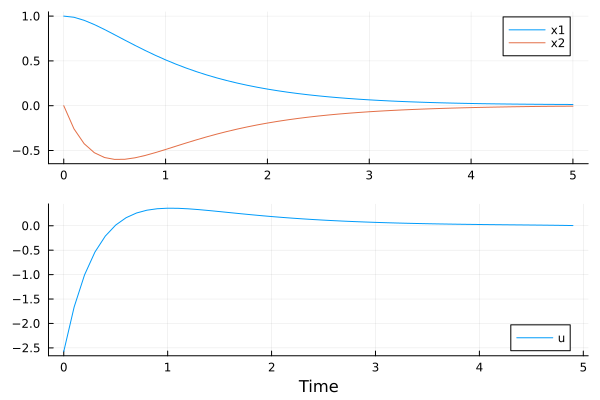

In [59]:

# Plot
l = @layout [a ; b]
p1 = plot(T, X', label=["x1" "x2"])
p2 = plot(T[1:end-1], U', label="u", xlabel="Time")
plot(p1, p2, layout = l)

### Practical
This is great we can solve an LQR problem. But let's take a quick look at the practicalities of this.

```{admonition} TODO
* Show "back-prop" through this suffers from vanishing gradients
* What is the time complexity

```


## Solving LQR via QP

Let's explore the structure of the OC program. If we stack all the decision variables into a vector $z$ then we will see the program has a familiar structure

$$
\begin{array}{ll}
\min _z & \frac{1}{z} z^{\intercal} H z \\
\text { s.t. } & C z=d
\end{array}
$$

Where the decision variables and weights are 

$$
z=\left[\begin{array}{c}
u_1 \\
x_2 \\
u_2 \\
x_3 \\
\vdots \\
x_N
\end{array}\right]
$$

$$
H=\left[\begin{array}{llllll}
R_1 & & & & & \\
& Q_2 & & & & \\
& & R_2 & & & \\
& & & Q_3 & & \\
& & & & \ddots \\
& & & & & Q_N
\end{array}\right]
$$
 
and the contstraints 

$$
\underbrace{\left[\begin{array}{cccccccc}
B & -T & 0 & 0 & \cdots & & & \\
& A & B & -I & 0 & \cdots & & \\
& & & A_{N-1} & B_M & -I
\end{array}\right]}_C \underbrace{\left[\begin{array}{c}
u_1 \\
x_2 \\
u_2 \\
\vdots \\
x_N
\end{array}\right]}_z=\underbrace{\left[\begin{array}{c}
-A x_1 \\
0 \\
0 \\
\vdots \\
0
\end{array}\right]}_d
$$

This is just a QP. At this point we could throw it at any old solver, but let's be a little more rigorous.

The Lagriangian of the QP is 

$$
L(z, \lambda)=\frac{1}{2} z^{\intercal} H z +\lambda^{\intercal}\left(Cz-d\right)
$$

and the KKT conditions

$$
\begin{aligned}
& \nabla_z L=Hz+C^{\top} \lambda=0 \\
& \nabla_\lambda L=Cz-d=0 \\
& \Rightarrow
\underbrace{\left[\begin{array}{ll}
H & C^{\top} \\
C & 0
\end{array}\right]}_{\text{KKT matrix}}

\left[\begin{array}{l}
z \\
\lambda
\end{array}\right]

=\left[\begin{array}{l}
0 \\
d
\end{array}\right]
\end{aligned}
$$

This is one big linear system. So that means we could get the solution through one Newton's method iteration! Let's give it a go.

In [60]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]
n = 2     # number of state
m = 1     # number of controls
Tfinal = 5.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [61]:
# Cost weights
Q = sparse(1.0*I(2))
R = sparse(0.1*I(1))
Qn = sparse(1.0*I(2))

#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

# Cost
H = blockdiag(R, kron(I(N-2), blockdiag(Q,R)), Qn);

In [62]:
# Constraints
C = kron(I(N-1), [B -I(2)])
for k = 1:N-2
    C[(k*n).+(1:n), (k*(n+m)-n).+(1:n)] .= A
end
d = [-A*x0; zeros(size(C,1)-n)];

In [63]:
# Solve the linear system
KKT = [H C'; C zeros(size(C, 1), size(C, 1))]
@show size(KKT)
y = KKT \ [zeros(size(H, 1)); d]

# Get state history
z = y[1:size(H, 1)]   # states and controls [u0,x1,u1,...,xN]
Z = reshape(z, n + m, N - 1)
xhist = Z[m+1:end, :]
xhist = [x0 xhist]

# Get control history
uhist = Z[1, :];
J(xhist, uhist)

size(KKT) = (250, 250)


6.658133166380834

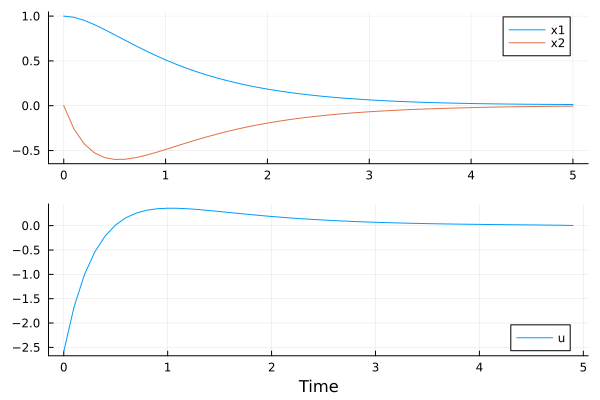

In [64]:
# Plot
times = range(0,h*(N-1), step=h)
l = @layout [a ; b]
p1 = plot(times, xhist', label=["x1" "x2"])
p2 = plot(times[1:end-1], uhist, label="u", xlabel="Time")
plot(p1, p2, layout = l)



```{admonition} TODO
* Discuss and show improvements in sparse and dense matrix (wall clock time)
* Show time complexity
* Show the solution with JUMP interface
```

## Solving LQR - Riccati Recursion
```{admonition} TODO
* Show time complexity 
```

## Summary
```{admonitions}
* Graph time complexity
```